# Digging Beneath the Surface

*Benjamin Johnson*


*March 2, 2018*

[Home](https://johnsbr1.github.io/)

[About Me](https://johnsbr1.github.io/author.html)

[Previous Entries](https://johnsbr1.github.io/posts.html)

## Parameter Optimization for Bill Bergen Fantasy Baseball

More baseball! In 2017, three fellow baseball nerds and myself formed the Bill Bergen Memorial Fantasy Baseball League. Being bored of the traditional formats, our goal was to create a league where the goal was for the WORST possible players to accumulate the HIGHEST points. By awarding points for batter strikeouts and subtracting for positive outcomes (hits, RBIs, runs), league managers would be incentivized to select the poorest performing postion players. Likewise, a similar scoring system was established for pitchers, awarding points for giving up hits & runs, while scoring negative points for getting outs. If you're curious about the league's namesake, I highly recommend the article [here](https://blogs.fangraphs.com/the-worst-hitter-in-baseball-history/).

&nbsp;

The idea was simple in concept, but this led to some headscratching when devising the rules. How many points should be awarded for each event?

&nbsp;

While the inaugural 2017 season was established with cherry-picked parameters, the purpose of this analysis was to optimize the parameters by creating the most negative relationship between the historical performance and fantasy rankings for traditional leagues.

&nbsp;

EDIT: The settings were successfully used in the 2018 season and maintained through 2021.

&nbsp;

While each section is documented with a header, I apologize for the lack of additional context. My goal will be to revisit this article and provide updated notes.

### Import libraries and define function

In [268]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import optimize

%matplotlib inline
matplotlib.style.use('ggplot')

def remove_whitespace(x):
    try:
        x = "".join(x.split())
    except:
        pass
    return x

### Read in fantasy projections

In [323]:
rank = pd.read_csv(r'C:\Users\johnsbr1\Documents\FantasyPros_Fantasy_Baseball_Rankings_ALL.csv',encoding = "ISO-8859-1")
rank['Name'] = rank['Player'].apply(remove_whitespace)
rank = rank[['Name','Rank']]
rank.head()

,Name,Rank
0,MikeTrout,1.0
1,JoseAltuve,2.0
2,NolanArenado,3.0
3,TreaTurner,4.0
4,PaulGoldschmidt,5.0


### Read in 2017 batting player stats

In [335]:
xl = pd.ExcelFile(r'C:\Users\johnsbr1\Documents\MLB 2017 Player Stats.xlsx')
batting = xl.parse("Batting")
#batting['Name'] = batting['Name'].str.strip()
batting['Name'] = batting['Name'].apply(remove_whitespace)
batting["1B"] = (batting['H'] - batting['HR'] - batting['3B'] - batting['2B'])
batting = batting[['Name','PA','BB','SO','1B','2B','3B','HR','SB','R','RBI']]
batting = batting[batting['PA'] >= 100]
batting.head()

,Name,PA,BB,SO,1B,2B,3B,HR,SB,R,RBI
0,A.J.Ellis,163,12,29,19,5,0,6,0,17,14
1,A.J.Pollock,466,35,71,60,33,6,14,20,73,49
2,AaronAltherr,412,32,104,53,24,5,19,5,58,65
3,AaronHicks,361,51,67,47,18,0,15,10,54,52
4,AaronJudge,678,127,208,75,24,3,52,9,128,114


### Read in 2017 pitching player stats

In [336]:
pitching = xl.parse("Pitching")
pitching['Name'] = pitching['Name'].apply(remove_whitespace)
pitching = pitching[['Name','G','W','L','IP','ER','H','BB','HR','SO','HBP','BK','WP']]
pitching = pitching[pitching['IP'] > 75]
pitching.head()


,Name,G,W,L,IP,ER,H,BB,HR,SO,HBP,BK,WP
1,A.J.Griffin,18,6,6,77.1,51,76,28,20,61,6,0,2
7,AaronNola,27,12,11,168.0,66,154,49,18,184,2,0,1
11,AdalbertoMejia,21,4,7,98.0,49,110,44,13,85,5,2,2
12,AdamConley,22,8,8,102.2,70,114,42,19,72,8,0,5
17,AdamWainwright,24,12,5,123.1,70,140,45,14,96,5,0,2


### Merge batting stats with fantasy rankings

In [337]:
batting_merge = pd.merge(batting, rank, how='inner',on='Name')
batting_merge.head()

,Name,PA,BB,SO,1B,2B,3B,HR,SB,R,RBI,Rank
0,A.J.Pollock,466,35,71,60,33,6,14,20,73,49,53.0
1,AaronAltherr,412,32,104,53,24,5,19,5,58,65,241.0
2,AaronHicks,361,51,67,47,18,0,15,10,54,52,252.0
3,AaronJudge,678,127,208,75,24,3,52,9,128,114,20.0
4,AbrahamAlmonte,195,20,46,26,8,3,3,2,26,14,664.0


### Define optimization function

In [338]:
batting_attr =  ['PA','BB','SO', '1B','2B','3B','HR','SB','R','RBI']
rank_array = batting_merge['Rank']

def bat_con(batting_values):
    values = np.zeros(len(rank_array)) 
    for i, j in enumerate(batting_attr):
        values = values + batting_merge[j] * batting_values[i]
    pct = len([1 for i in values if i > 0])/len(values)
    return pct - 0.7

bat_cons = {'type':'ineq', 'fun': bat_con}

def bat_funct(batting_values):
    values = np.zeros(len(rank_array)) 
    for i, j in enumerate(batting_attr):
        values = values + batting_merge[j] * batting_values[i]
    batting_merge['values'] = values
    return(-1 * np.corrcoef(batting_merge['values'], batting_merge['Rank'])[1,0])

### Evaluate correlation using 2017 parameter set

In [339]:
# batting_attr =  ['PA','BB','SO', '1B','2B','3B','HR','SB','R','RBI']
initial =          [2.5, -3.0, 2.0, -2.5, -5, -6, -10, -10, -6, -7]
orig = bat_funct(initial)

pct =  len(batting_merge[batting_merge['values'] > 0])/len(batting_merge['values'])

print("The correlation coefficient for the 2017 parameter set is " + str(orig))
print("The percentage of players with positive scores is " + str(pct))

The correlation coefficient for the 2017 parameter set is -0.6379982107056971
The percentage of players with positive scores is 0.4519230769230769


### Run optimization to find new parameter set

In [304]:
opt_model= optimize.minimize(bat_funct, x0=initial, method='COBYLA', constraints=bat_cons) 
opt_values = opt_model.x
opt = bat_funct(opt_values)
print("The correlation coefficient for the optimized parameter set is " + str(opt))
print("The parameter set is as follows: " + str(opt_values))

The correlation coefficient for the optimized parameter set is -0.5742293816349405
The parameter set is as follows: [  2.502502    -2.73139892   2.64238572  -2.55086712  -5.04848268
  -5.77686603  -9.92309256 -10.01061392  -5.71442201  -6.72205971]


### Manually tweak settings (rounding + common sense, e.g. HR > 3B)

In [306]:
#batting_attr =  ['PA','BB','SO', '1B','2B','3B','HR','SB','R','RBI']
opt_values2 =    [2.5, -2.5, 2.5,  -2.5, -5,  -6,  -10, -10, -5.5, -6.5]
opt2 = bat_funct(opt_values2)

pct =  len(batting_merge[batting_merge['values'] > 0])/len(batting_merge['values'])

print("The correlation coefficient for the optimized parameter set is " + str(opt2))
print("The percentage of players with positive scores is " + str(pct))

The correlation coefficient for the optimized parameter set is -0.5580190666336041
The percentage of players with positive scores is 0.6826923076923077


## Create scatterplot

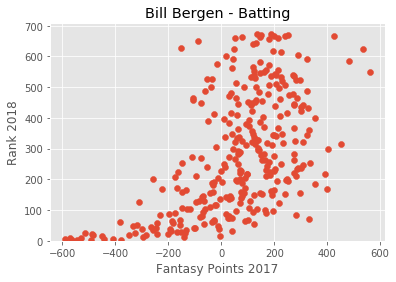

In [307]:
plt.scatter(batting_merge['values'], batting_merge['Rank'])

plt.ylim(0)
plt.title('Bill Bergen - Batting')
plt.xlabel('Fantasy Points 2017')
plt.ylabel('Rank 2018')
plt.show()


### Repeat for pitchers

In [340]:
pitching_merge = pd.merge(pitching, rank, how='inner',on='Name')
pitching_merge.head()

,Name,G,W,L,IP,ER,H,BB,HR,SO,HBP,BK,WP,Rank
0,AaronNola,27,12,11,168.0,66,154,49,18,184,2,0,1,70.0
1,AdalbertoMejia,21,4,7,98.0,49,110,44,13,85,5,2,2,636.0
2,AdamConley,22,8,8,102.2,70,114,42,19,72,8,0,5,590.0
3,AdamWainwright,24,12,5,123.1,70,140,45,14,96,5,0,2,491.0
4,AddisonReed,77,2,3,76.0,24,65,15,11,76,1,0,2,317.0


In [341]:
pitching_attr =  ['HR','BB','SO','WP','ER','L','BK']
rank_array = pitching_merge['Rank']

def pitch_con(pitching_values):
    values = np.zeros(len(rank_array)) 
    for i, j in enumerate(pitching_attr):
        values = values + pitching_merge[j] * pitching_values[i]
    pct = len([1 for i in values if i > 0])/len(values)
    return pct - 0.7

pitch_cons = {'type':'ineq', 'fun': pitch_con}

def pitch_funct(pitching_values):
    values = np.zeros(len(rank_array)) 
    for i, j in enumerate(pitching_attr):
        values = values + pitching_merge[j] * pitching_values[i]
    pitching_merge['values'] = values
    return(-1 * np.corrcoef(pitching_merge['values'], pitching_merge['Rank'])[1,0])

In [342]:
# pitching_attr =  ['HR','BB','SO','WP','ER','L','BK']
initial =          [5,    3,   -3,  3,   3,   5,   3]
orig = pitch_funct(initial)

pct =  len(pitching_merge[pitching_merge['values'] > 0])/len(pitching_merge['values'])

print("The correlation coefficient for the 2017 parameter set is " + str(orig))
print("The percentage of players with positive scores is " + str(pct))

The correlation coefficient for the 2017 parameter set is -0.7003489760779815
The percentage of players with positive scores is 0.7702702702702703


In [343]:
opt_model= optimize.minimize(pitch_funct, x0=initial, method='COBYLA', constraints=pitch_cons) 
opt_values = opt_model.x
opt = pitch_funct(opt_values)
print("The correlation coefficient for the optimized parameter set is " + str(opt))
print("The parameter set is as follows: " + str(opt_values))

The correlation coefficient for the optimized parameter set is -0.7376310027253765
The parameter set is as follows: [ 4.77148409  2.62001697 -3.17204613  3.33320318  2.78947702  5.07084826
  3.95074218]


In [344]:
# pitching_attr =  ['HR','BB','SO','WP','ER','L','BK']
opt_values2 =      [ 4.5, 4,  -3, 3.5,  2.5, 4.5,  3 ]
opt2 = pitch_funct(opt_values2)

pct =  len(pitching_merge[pitching_merge['values'] > 0])/len(pitching_merge['values'])

print("The correlation coefficient for the optimized parameter set is " + str(opt2))
print("The percentage of players with positive scores is " + str(pct))

The correlation coefficient for the optimized parameter set is -0.6950827175798062
The percentage of players with positive scores is 0.777027027027027


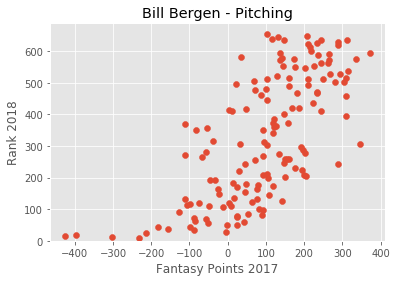

In [345]:
plt.scatter(pitching_merge['values'], pitching_merge['Rank'])

plt.ylim(0)
plt.title('Bill Bergen - Pitching')
plt.xlabel('Fantasy Points 2017')
plt.ylabel('Rank 2018')
plt.show()
